### Importing the necessary libraries

In [64]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import Sequential
from keras.layers import Dense
from ann_visualizer.visualize import ann_viz

### Importing Data and manipulating it

In [2]:
# open the csv file and read it
data = pd.read_csv('diabetes_data_upload.csv')

In [3]:
# discretizing the Age data into three groups, based on the medical opinion for diabetes
data['Age'] = data['Age'].mask(data['Age'] < 40, 1)
data['Age'] = data['Age'].mask(data['Age'] >= 65, 3)
data['Age'] = data['Age'].mask(data['Age'] >= 40, 2)

In [4]:
# convert binary string data into 1 and 0 
data = data.mask(data == 'Yes', 1)
data = data.mask(data == 'No', 0)
data = data.mask(data == 'Male', 1)
data = data.mask(data == 'Female', 0)
data = data.mask(data == 'Positive', 1)
data = data.mask(data == 'Negative', 0)
data.iloc[:,:] = data.iloc[:,:].astype(int)

In [5]:
# display the first 10 rows
data.head(10)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,2,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,2,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,2,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,2,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
5,2,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,1
6,2,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1
7,3,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0,1
8,3,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1
9,3,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1


### Machine Learning Models

#### Building the decision tree model

In [73]:
# function responsible to create a decision tree based on the dataset you provide
def dtModel(dataset):
    # dividing dataset into X (features, input) and Y (class, output) 
    X = dataset.iloc[:,:len(dataset.columns)-1]
    Y = dataset.iloc[:,len(dataset.columns)-1]
    # splitting dataset intp X and Y train, and X and Y test subsets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    # creating the classification model by building a decision tree
    dt = tree.DecisionTreeClassifier()
    # adjusting weights according to data values so that better accuracy can be achieved
    dt.fit(X_train, Y_train)

    # testing model and printing the classification report (quality of predictions)
    Y_pred = dt.predict(X_test)
    print(metrics.classification_report(Y_test,Y_pred))
    
    # displaying the confusion matrix on a heatmap
    mat = confusion_matrix(Y_test, Y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        58
           1       0.95      0.99      0.97        72

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130



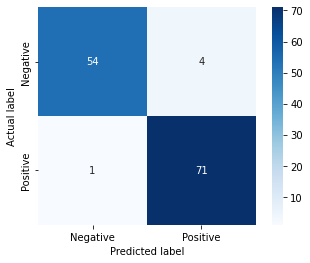

In [74]:
# trying the model
dtModel(data)

#### Decision tree pruning

In [8]:
# measuring k highest scores for each feature to lowering the overfitting
array = data.values
X = array[:,0:len(data.columns)-1]
Y = array[:,len(data.columns)-1]

# Feature extraction
test = SelectKBest(score_func=chi2)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[1.895e-01 3.875e+01 1.162e+02 1.208e+02 5.775e+01 1.272e+01 3.320e+01
 4.914e+00 1.812e+01 4.783e-02 3.533e+01 6.202e-01 5.531e+01 4.875e+00
 2.440e+01 2.250e+00]


In [9]:
# removing featrues that doesn't help in building the tree
dataNew = data.drop(columns=['Age', 'Itching', 'delayed healing', 'Genital thrush', 'muscle stiffness', 'Obesity'])

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        49
           1       0.96      0.96      0.96        81

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130



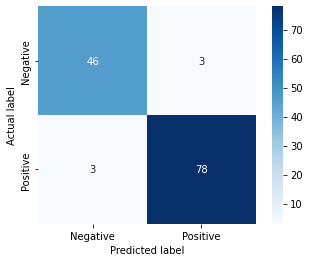

In [75]:
# trying pruned model
dtModel(dataNew)

#### Building a logistic regression model

In [71]:
# function responsible to create a logistic regression model based on the dataset you provide
def logReg(dataset):
    # dividing dataset into X (features, input) and Y (class, output) 
    x = dataset.iloc[:,:len(dataset.columns)-1]
    y = dataset.iloc[:,len(dataset.columns)-1]
    
    # splitting dataset intp X and Y train, and X and Y test subsets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
    
    # creating the classification model
    classifier = LogisticRegression(random_state = 0)
    # adjusting weights according to data values so that better accuracy can be achieved
    classifier.fit(x_train, y_train)
    
    # testing model and printing the classification report (quality of predictions)
    y_pred = classifier.predict(x_test)
    print(metrics.classification_report(y_test,y_pred))

    # displaying the confusion matrix on a heatmap
    mat = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')


              precision    recall  f1-score   support

           0       0.96      0.89      0.93        56
           1       0.92      0.97      0.95        74

    accuracy                           0.94       130
   macro avg       0.94      0.93      0.94       130
weighted avg       0.94      0.94      0.94       130



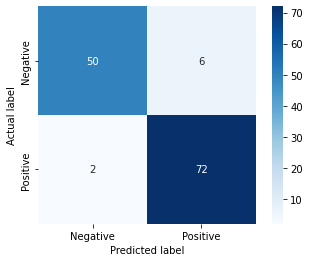

In [72]:
logReg(data)

#### Building a neural network model

In [80]:
# function responsible to create a neural network model based on the dataset you provide
def neuNet(dataset):
    # creating input features and class variables
    X = dataset.iloc[:,0:len(dataset.columns)-1]
    y = dataset.iloc[:,len(dataset.columns)-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=len(dataset.columns)-1))
    #Second  Hidden Layer
    #classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    #Fitting the data to the training dataset
    classifier.fit(X_train,y_train, batch_size=10, epochs=100)
    
    eval_model = classifier.evaluate(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred>0.5)
    
    mat = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    #ann_viz(classifier, title="Early stage diabetes risk prediction")

Epoch 1/100
37/37 [==============================] - 1s 1ms/step - loss: 0.6915 - accuracy: 0.6236
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.6071
Epoch 3/100
37/37 [==============================] - 0s 927us/step - loss: 0.6843 - accuracy: 0.6236
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6788 - accuracy: 0.7363
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6721 - accuracy: 0.7775
Epoch 6/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.8681
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6552 - accuracy: 0.9148
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6455 - accuracy: 0.8956
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6341 - accuracy: 0.9038
Epoch 10/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6227 - accuracy: 0.8956
Epoch 1

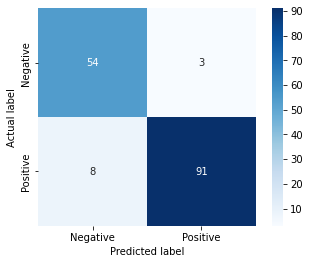

In [81]:
neuNet(data)